Inicialização

In [1]:
import random
import math
import numpy as np
from collections import deque
#import matplotlib
#import matplotlib.pyplot as plt
import signal
import pickle
import glob
import pandas as pd
#from mpl_toolkits.mplot3d import Axes3D  

#import plotly.plotly as py
import plotly
import plotly.io as pio
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

plotly.offline.init_notebook_mode(connected=True)

In [54]:

loadRange = [0,None] #Loads the data partially. Lower and upper bound

def normalize(list, range): # range should be (lower_bound, upper_bound)
    l = np.array(list) 
    a = np.max(l)
    c = np.min(l)
    b = range[1]
    d = range[0]

    m = (b - d) / (a - c)
    pslope = (m * (l - c)) + d
    return pslope

def calcAvgOfX(scores, avgx):
    y1 = []

    for pos in range(0, len(scores), avgx):
        y1.append(np.average(scores[pos:pos+avgx]))

    return y1

def calcAvgOfXMinMax(scores, avgx):
    y1 = []
    min_ = []
    max_ = []

    for pos in range(0, len(scores), avgx):
        y1.append(np.average(scores[pos:pos+avgx]))
        min_.append(np.amin(scores[pos:pos+avgx]))
        max_.append(np.amax(scores[pos:pos+avgx]))

    return [y1,min_,max_]

def countPosNeg(y1):
    negatives = sum(n < 0 for n in y1)
    positives = sum(n > 0 for n in y1)
    zeroes = sum(n == 0 for n in y1)
    return [negatives, zeroes, positives]

def countWeightedPosNeg(y1):
    negatives = sum(n if (n <  0) else 0 for n in y1)
    positives = sum(n if (n >  0) else 0 for n in y1)
    zeroes =    sum(n if (n == 0) else 0 for n in y1)
    return [negatives, zeroes, positives]

def loadFiles(loadgroups):
    files = glob.glob("*.pickle")
    files = [x.replace(".pickle", "") for x in files]
    unpacked = []
    for x in files:
        for acp in loadgroups:
            if x.endswith(acp):
                with open(x+".pickle", 'rb') as handle:
                    unpacked.append([x,pickle.load(handle)[loadRange[0]:loadRange[1]]])
                break
    return unpacked

In [55]:
# Flushed Replay
# groups = {  'clearReplay' : 'orange' }
# forgetting1 = 1400
# forgetting2 = 6570
# colorize=True

#Forgetting parts
groups = {  'testForgetting2' : 'blue' }
forgetting1 = 3620
forgetting2 = 6570
colorize=True

blim = None
ulim = None
title = 'Assault - Atari'
ctitle = 'Forgetting'   


# groups = {    
#     'DRQN' : 'blue',
#     'DQN' : 'red',
#     'Random' : 'black',
#     }
# colorize=False

loadedfile = loadFiles(groups)

# Column headers in data matrix
columnsofdt = ['SCORE', 'MAX SCORE', 'AVG SCORE', 'AVG MAX SCORE', 'EPISODE']

processed = {}

def getLabelName(inp, dictx):
    for x in dictx:
        if inp.endswith(x):
            return x
    return None



for runtst in loadedfile:
    posIn = getLabelName(runtst[0], groups)
    if posIn in processed:
        processed[posIn] = np.average([processed[posIn], runtst[1]], axis=0)
    else:
        processed[posIn] = runtst[1]



        
count = 0




In [11]:


def calcAvgOfXWStrides(scores, avgx, strides):
    y1 = []

    for pos in range(0, len(scores), strides):
        y1.append(np.average(scores[pos:pos+avgx]))

    return y1



def addToPlotAvgOfXWStrides(scores, avg, labelx, col, strides, posx=1, maxpos=1, padding=0.3, title=""):
    y1 = calcAvgOfXWStrides(scores, avg, strides)
    y2 = calcAvgOfXWStrides(scores, 100, 1)
    alphaChannel = "1"
    
    x = np.array([i for i in range(0, len(y1))])
    pospad = (1/maxpos)-padding/maxpos
    posit = (x-pospad)+(posx*pospad)

    colors = ["rgba(10, 200, 10, 1)" for x in range(0,3620//1)]
    colors.extend(["rgba(200, 200, 10, 1)" for x in range(3620//1,6570//1)])
    colors.extend(["rgba(200, 10, 10, 1)" for x in range(6570//1,len(y1))])

    
    
#     if(colorize):
#         blueshift = [0 for x in range(0,forgetting1)]
#         blueshift.extend([150 for x in range(forgetting1,forgetting2)])
#         blueshift.extend([255 for x in range(forgetting2,len(y1))])

    
# #     diffd = np.subtract(y1,y2)

# #     ptp = np.ptp(diffd).astype(int)
# #     internal = (diffd - np.min(diffd))
# #     l_norm =  255*np.divide(internal,ptp)

#     if(colorize):
#         #colors = ["rgba(10, "+str(abs(l_norm[x]))+", "+str(blueshift[x])+", "+alphaChannel+")" if y1[x] > y2[x] else "rgba(10, 10, "+str(blueshift[x])+", "+alphaChannel+")" if y1[x] == y2[x] else "rgba("+str(abs(l_norm[x]))+", 10, "+str(blueshift[x])+", "+alphaChannel+")"  for x in range(0,len(y1))]
#         colors = ["rgba(10, 100, "+
#                               str(blueshift[x])+", "+
#                               alphaChannel+")" for x in range(0,len(y1))]
                                  
    trace1 = go.Scattergl(
        x=posit,
        y=y1,
        mode='markers',
        name=labelx,
        marker=dict(
            size=6, 
            color=col if colorize is False else colors,
            opacity=float(alphaChannel)
            #color=colors,
            #line=dict(
            #    color='rgba(217, 217, 217, 0.14)',
            #    width=pospad
            #),
            
        ),
        
    )
    return trace1

    
def plotAndSaveContinuousAverageOf(customTitle,title,averageOf = 1,blim=None, ulim=None,customLabel = None, posx = 1, maxn = 1):
    data = []
    avgOfTxt = ' - Average of ' + str(averageOf) #if averageOf > 1 else ""
    txtSide = "Avg" if  averageOf > 1 else "Raw"
    xaxisName = "Episode Window" if  averageOf > 1 else "Episode Window"
    for runtst in processed:
        dtframe = processed[runtst]
        label = runtst
        #if customLabel is not None:
        #    label=customLabel
        color = groups[runtst]

        print("Processing: " + label)
        dataframe = pd.DataFrame(data=dtframe, columns=columnsofdt)
        scores = dataframe['SCORE']
        
        trace1 = addToPlotAvgOfXWStrides(scores, averageOf, label, color, 1, title=title)
        data.append(trace1)
    layout = go.Layout(
        title=go.layout.Title(
        text="<b>"+title+ avgOfTxt + "</b>",
        xref='paper',
        x=0
        ),

        legend=dict(
            orientation="h",
            x=0,
            y=1,
            traceorder='normal',
            font=dict(
                family='sans-serif',
                size=18,
                color='#000'
            ),
            bgcolor='#E2E2E2',
            bordercolor='#FFFFFF',
            borderwidth=2),
        margin=go.layout.Margin(
        l=80,
        r=20,
        b=80,
        t=50,
        pad=10),


                    xaxis = dict(
                         title='<b>'+xaxisName+'</b>',

                        mirror=True,
                        ticks='outside',
                        showline=True,
                        tickfont=dict(
                            family='Arial',
                            size=18,
                            color='rgb(0, 0, 0)',),


                    ),
                    yaxis = dict(
                        title='<b>'+txtSide+'Reward</b>',
                        mirror=True,
                        ticks='outside',
                        showline=True,
                        range=[0, 7000],
                        #ticksuffix="</b>",
                        #tickprefix="<b>",
                        tickwidth=3,
                        tickfont=dict(
                            family='Arial',
                            size=18,
                            color='rgb(0, 0, 0)',),
                    )
         )
    fig = go.Figure(data=data, layout=layout)
    iplot(fig, filename=title+' CAVGoF'+str(averageOf)+'-'+str(random.randint(1,50000)))
    print("Done")
    





In [12]:
plotAndSaveContinuousAverageOf(ctitle,title,1,blim,ulim,ctitle)

Processing: Random
Processing: DRQN
Processing: DQN


Done


In [13]:
plotAndSaveContinuousAverageOf(ctitle,title,10,blim,ulim,ctitle)


Processing: Random
Processing: DRQN
Processing: DQN


Done


In [14]:
plotAndSaveContinuousAverageOf(ctitle,title,100,blim,ulim,ctitle)

Processing: Random
Processing: DRQN
Processing: DQN


Done


# Non-continuous average

In [8]:
def plotAndSaveAverageOf(customTitle,title,averageOf = 1,blim=None, ulim=None,customLabel = None, posx = 1, maxn = 1):
    for runtst in processed:
        dtframe = processed[runtst]
        label = runtst
        if customLabel is not None:
            label=customLabel
        color = groups[runtst]
        print("Processing: " + label)
        dataframe = pd.DataFrame(data=dtframe, columns=columnsofdt)
        scores = dataframe['SCORE']
        
        addToPlotAvgOfX(scores, averageOf, label, color, title=title)

    print("Done!")
    
    
def addToPlotAvgOfX(scores, avg, labelx, col, posx=1, maxpos=1, padding=0.3, title=""):
    y1 = calcAvgOfX(scores, avg)

    x = np.array([i for i in range(0, len(y1))])
    pospad = (1/maxpos)-padding/maxpos
    posit = (x-pospad)+(posx*pospad)
    xs = np.linspace(0, len(y1), len(y1))

    colors = ["rgba(10, 200, 10, 1)" for x in range(0,3620//avg)]
    colors.extend(["rgba(200, 200, 10, 1)" for x in range(3620//avg,6570//avg)])
    colors.extend(["rgba(200, 10, 10, 1)" for x in range(6570//avg,len(y1))])
    
    trace1 = go.Scattergl(
        x=posit,
        y=y1,
        mode='markers',
        marker=dict(
            size=6,
            color=colors,
            line=dict(
                color='rgba(217, 217, 217, 0.14)',
                
                width=pospad
            ),
            opacity=0.8
        ),
        name=title
    )
    data = [trace1]
    layout = go.Layout(
        title=go.layout.Title(
        text=title+ (' - Average of ' + str(avg) if avg > 1 else ""),
        xref='paper',
        x=0
        ),
        xaxis = dict(
                         
                         title='Step'),
                    yaxis = dict(
                        
                        title='Score')
    )
    fig = go.Figure(data=data, layout=layout)
    iplot(fig, filename=title+' AvgOf' + str(avg)+'-'+str(random.randint(1,50000)))


Processing: Forgetting


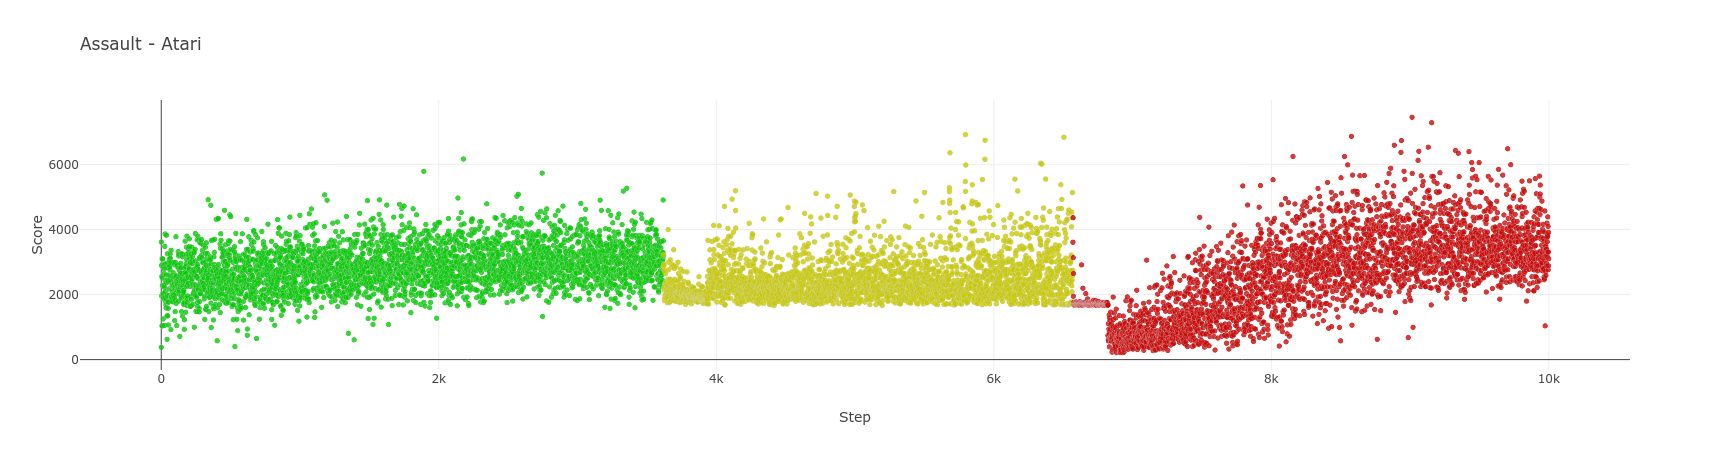

Done!


In [9]:
plotAndSaveAverageOf(ctitle,title,1,blim,ulim,ctitle)

Processing: Forgetting


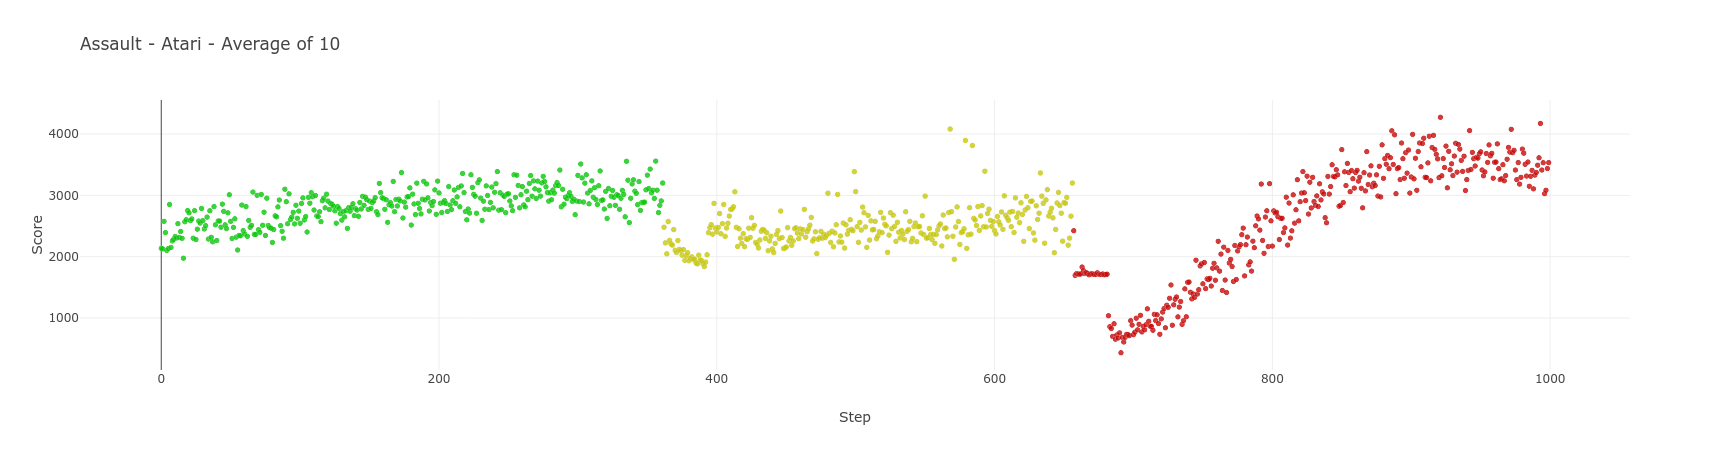

Done!


In [10]:
plotAndSaveAverageOf(ctitle,title,10,blim,ulim,ctitle)


Processing: Forgetting


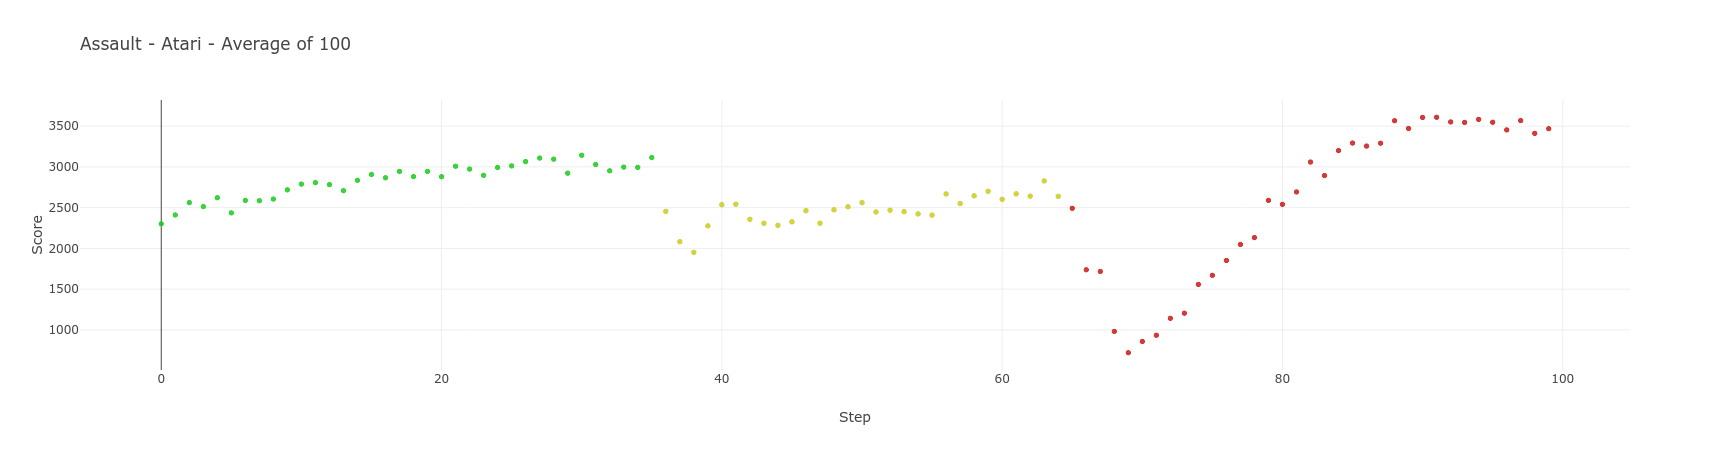

Done!


In [11]:
plotAndSaveAverageOf(ctitle,title,100,blim,ulim,ctitle)

# Progressive Difference

In [58]:
tickdistance = 200
_USE_NORMALIZED_VALUES_ = False

def genDiffProg(scores_, avg, labelx, col, posx=1, maxpos=1, padding=0.3):
    scores = calcAvgOfX(scores_, avg)
    y1 = [0]
    for pos in range(0, len(scores)-1, 1):
        y1.append((scores[pos+1] - scores[pos]))
    y1.extend([0])
    return y1


def addToPlotDiffProg(scores_, avg, labelx, col, posx=1, maxpos=1, padding=0.3, title=""):
    posx=1
    maxpos=1 
    padding=0.3
    y1 = genDiffProg(scores_,avg, labelx, col, posx, maxpos, padding) #[2300:2330]
    alphaChannel = "1"
    print(countPosNeg(y1))
    print(countWeightedPosNeg(y1))
    x = np.array([i for i in range(0, len(y1))])                      #+2300
    #pospad = (1/maxpos)-padding/maxpos
    #posit = (x-pospad)+(posx*pospad)
    maxy = np.max(np.abs(y1))
    print(["maxy", maxy])
    
    alphaChannel = "1"
    #     if(colorize):
    #         blueshift = [0 for x in range(0,forgetting1//avg)]
    #         blueshift.extend([150 for x in range(forgetting1//avg,forgetting2//avg)])
    #         blueshift.extend([255 for x in range(forgetting2//avg,len(y1))])
    if(colorize):
        colors = ["rgba(10, 200, 10, 1)" for x in range(0,forgetting1//avg)]
        colors.extend(["rgba(200, 200, 10, 1)" for x in range(forgetting1//avg,forgetting2//avg)])
        colors.extend(["rgba(200, 10, 10, 1)" for x in range(forgetting2//avg,len(y1))])

    


    
    
    trace1 = go.Bar(
        x=x,
        y=normalize(y1,[-1,1]) if _USE_NORMALIZED_VALUES_ else y1,
        name=labelx,
        marker=dict(
            
            color=col if colorize is False else colors,
            opacity=float(alphaChannel)
        ),
        
    )
    return trace1

def plotAndSaveForwardDifference(customTitle,title,averageOf = 1,blim=None, ulim=None,customLabel = None, posx = 1, maxn = 1):
    data = []
    avgOfTxt = ' - Average of ' + str(averageOf) #if averageOf > 1 else ""
    txtSide = "Avg" if  averageOf > 1 else "Raw"
    xaxisName = "Episode Window" #if  averageOf > 1 else "Episode"
    #order = ["DRQN","Random","DQN"]
    #for runtst in order:
    for runtst in processed:
    
        dtframe = processed[runtst]
        label = runtst
        #if customLabel is not None:
        #    label=customLabel
        color = groups[runtst]

        print("Processing: " + label)
        dataframe = pd.DataFrame(data=dtframe, columns=columnsofdt)
        scores = dataframe['SCORE']
        
        trace1 =addToPlotDiffProg(scores, averageOf, label, color, posx, maxn, title=title)
        data.append(trace1)
    
    
    layout = go.Layout(
        title=go.layout.Title(
        text="<b>"+title+ 
            (' - Average Difference of ' 
             + str(averageOf) if averageOf > 1 else "")+ "</b>",
        xref='paper',
        x=0
        ),
        legend=dict(
            orientation="h",
            x=0,
            y=1,
            traceorder='normal',
            font=dict(
                family='sans-serif',
                size=18,
                color='#000'
            ),
            bgcolor='#E2E2E2',
            bordercolor='#FFFFFF',
            borderwidth=2),
        margin=go.layout.Margin(
        l=80,
        r=20,
        b=50,
        t=50,
        pad=4),
        barmode='group',
        xaxis = dict(
                    title='<b>'+xaxisName+'</b>',
                    mirror=True,
                    ticks='outside',
                    showline=True,
                    tickfont=dict(
                        family='Arial',
                        size=18,
                        color='rgb(0, 0, 0)',)),
                yaxis = dict(
                    mirror=True,
                    ticks='outside',
                    showline=True,
                    #range=[maxy*-1-500, maxy+500],
                    #nticks=int(np.ceil(maxy/tickdistance))*2+1,
                    title='<b>'+'DBS'+'</b>',
                    tickwidth=3,
                    tickfont=dict(
                        family='Arial',
                        size=18,
                        color='rgb(0, 0, 0)',)))
    
                        
                    
                  
    
    fig = go.Figure(data=data, layout=layout)
    filename=title+'DiffProg'+str(random.randint(1,50000))
    iplot(fig,  filename=filename)
    #pio.write_image(fig, filename+'.svg')

        
        
    print("Done!")

In [22]:
plotAndSaveForwardDifference(ctitle,title,1,blim,ulim,ctitle)


Processing: DRQN
[1521, 3, 1477]
[-1353164.0, 0.0, 1356173.0]
['maxy', 4443.0]
Processing: Random
[1523, 5, 1473]
[-675048.0, 0.0, 675975.0]
['maxy', 2892.0]
Processing: DQN
[1495, 12, 1494]
[-248341.0, 0.0, 248048.0]
['maxy', 1813.0]


Done!


In [17]:
plotAndSaveForwardDifference(ctitle,title,10,blim,ulim,ctitle)


Processing: DRQN
[141, 1, 158]
[-41517.799999999996, 0, 44366.29999999999]
['maxy', 1024.7000000000003]
Processing: Random
[149, 1, 150]
[-22892.30000000001, 0, 22943.50000000001]
['maxy', 626.8]
Processing: DQN
[151, 1, 148]
[-8865.700000000003, 0, 8500.1]
['maxy', 282.5000000000001]


Done!


In [59]:
plotAndSaveForwardDifference(ctitle,title,100,blim,ulim,ctitle)

Processing: testForgetting2
[44, 2, 55]
[-5800.869999999998, 0, 6967.749999999998]
['maxy', 754.7099999999998]


Done!


In [194]:
plotAndSaveForwardDifference(ctitle,title,1000,blim,ulim,ctitle)

Processing: testForgetting2
[4, 1, 5]
[-1517.7010000000005, 0, 2518.1740000000004]
['maxy', 1526.8580000000002]


Done!


# Average Hibrid

In [64]:
def addToPlotDiffAvgWProg(scores_, avg, labelx, col, posx=1, maxpos=1, padding=0.3, title=""):
    y1 = genDiffProg(scores_,avg, labelx, col, posx, maxpos, padding)
    scores = calcAvgOfX(scores_, avg)

    print(countPosNeg(y1))
    print(countWeightedPosNeg(y1))
    x = np.array([i for i in range(0, len(y1))])
    pospad = (1/maxpos)-padding/maxpos
    posit = (x-pospad)+(posx*pospad)

    print(len(y1))
    print(len(scores))
    print(len(posit))
    colors = ["rgba(10, 200, 10, 1)" for x in range(0,3620//avg)]
    colors.extend(["rgba(200, 200, 10, 1)" for x in range(3620//avg,6570//avg)])
    colors.extend(["rgba(200, 10, 10, 1)" for x in range(6570//avg,len(y1))])

    trace1 = go.Scatter3d(
        x=posit,
        y=normalize(y1,[-0.5,0.5]),
        z=normalize(scores,[0,1]),
        mode='markers',
        
        marker=dict(
            size=6,
            color=colors,
            line=dict(
                color='rgba(217, 217, 217, 0.08)',
                width=0.02
            ),
            opacity=0.8
        ),
        name=title
    )
    data = [trace1]
    layout = go.Layout(
        title=go.layout.Title(
        text="<b>"+title+' - Average of ' + str(avg)+ "</b>",
        xref='paper',
        x=0
        ),
        margin=go.layout.Margin(
        l=20,
        r=20,
        b=20,
        t=40,
        pad=10),
        scene = dict(
            
                    zaxis = dict(
                         backgroundcolor="rgb(200, 200, 230)",
                         gridcolor="rgb(255, 255, 255)",
                         showbackground=True,
                         mirror=True,
                         ticks='outside',
                         showline=True,
                        tickfont=dict(
                            family='Arial',
                            size=18,
                            color='rgb(0, 0, 0)',),
                         zerolinecolor="rgb(255, 255, 255)",
                         title='<b>'+'Scores'+'</b>'),
                    yaxis = dict(
                        backgroundcolor="rgb(230, 200,230)",
                        gridcolor="rgb(255, 255, 255)",
                        showbackground=True,
                        mirror=True,
                        ticks='outside',
                        showline=True,
                        tickfont=dict(
                            family='Arial',
                            size=18,
                            color='rgb(0, 0, 0)',),
                        zerolinecolor="rgb(255, 255, 255)",
                        title='<b>'+'DBS'+'</b>'),
                    xaxis = dict(
                        backgroundcolor="rgb(230, 230,200)",
                        gridcolor="rgb(255, 255, 255)",
                        showbackground=True,
                        mirror=True,
                        ticks='outside',
                        showline=True,
                        tickfont=dict(
                            family='Arial',
                            size=18,
                            color='rgb(0, 0, 0)',),
                        zerolinecolor="rgb(255, 255, 255)",
                        title='<b>'+'Episode Window'+'</b>'),)
                        
                    
                  
    )
    fig = go.Figure(data=data, layout=layout)
    iplot(fig, filename=title+'-avgOf' + str(avg)+'-'+str(random.randint(1,50000)))




def plotAndSaveHib(customTitle,title,averageOf = 1,blim=None, ulim=None,customLabel = None, posx = 1, maxn = 1):
    for runtst in processed:
        dtframe = processed[runtst]
        label = runtst
        if customLabel is not None:
            label=customLabel
        color = groups[runtst]

        print("Processing: " + label)
        dataframe = pd.DataFrame(data=dtframe, columns=columnsofdt)
        scores = dataframe['SCORE']

        addToPlotDiffAvgWProg(scores, averageOf, label, color, title=title)

    print("Done!")

In [61]:
plotAndSaveHib(ctitle,title,1,blim,ulim,ctitle)

Processing: Forgetting
[5031, 9, 4961]
[-3581962.0, 0.0, 3584684.0]
10001
10000
10001


Done!


In [65]:
plotAndSaveHib(ctitle,title,10,blim,ulim,ctitle)

Processing: Forgetting
[494, 2, 505]
[-122152.19999999997, 0, 123549.69999999991]
1001
1000
1001


Done!


In [66]:
plotAndSaveHib(ctitle,title,100,blim,ulim,ctitle)

Processing: Forgetting
[44, 2, 55]
[-5800.869999999998, 0, 6967.749999999998]
101
100
101


Done!


# Min Max

In [43]:
def addToPlotMinMax(scores_, avg, labelx, col, posx=1, maxpos=1, padding=0.3, title=""):

    y1 = []

    for pos in range(0, len(scores_), avg):
        y1.append((np.amax(scores_[pos:pos+avg]) - 
                   np.amin(scores_[pos:pos+avg]))/np.average(scores_[pos:pos+avg]))
    x = np.array([i for i in range(0, len(y1))])
    pospad = (1/maxpos)-padding/maxpos
    posit = (x-pospad)+(posx*pospad)
    colors = ["rgba(10, 200, 10, 1)" for x in range(0,3620//avg)]
    colors.extend(["rgba(200, 200, 10, 1)" for x in range(3620//avg,6570//avg)])
    colors.extend(["rgba(200, 10, 10, 1)" for x in range(6570//avg,len(y1))])

    print(len(y1))
    print(len(posit))
    trace1 = go.Scatter(
        x=posit,
        y=y1,
        mode='markers',
        marker=dict(
            size=6,
            color=colors,
            line=dict(
                color='rgba(217, 217, 217, 0.14)',
                
                width=pospad
            ),
            opacity=0.8
        ),
        name=title
    )
    data = [trace1]
    layout = go.Layout(
        title=go.layout.Title(
        text="<b>"+title+' - Average of ' + str(avg)+ "</b>",
        xref='paper',
        x=0
        ),
        legend=dict(
            orientation="h",
            x=0,
            y=1,
            traceorder='normal',
            font=dict(
                family='sans-serif',
                size=18,
                color='#000'
            ),
            bgcolor='#E2E2E2',
            bordercolor='#FFFFFF',
            borderwidth=2),
        margin=go.layout.Margin(
        l=80,
        r=20,
        b=80,
        t=50,
        pad=10),
                    xaxis = dict(
                        tickwidth=3,
                        mirror=True,
                        ticks='outside',
                        showline=True,
                        tickfont=dict(
                            family='Arial',
                            size=18,
                            color='rgb(0, 0, 0)',),
                         title='<b>'+'Step'+'</b>'),
                    yaxis = dict(
                        tickwidth=3,
                        mirror=True,
                        ticks='outside',
                        showline=True,
                        tickfont=dict(
                            family='Arial',
                            size=18,
                            color='rgb(0, 0, 0)',),
                        title='<b>'+'Difference'+'</b>')
    )
    fig = go.Figure(data=data, layout=layout)
    iplot(fig, filename=title+' MinMax' + str(avg)+'-'+str(random.randint(1,50000)))
    

def plotAndSaveAvgMinMaxOf(customTitle,title,averageOf = 1,blim=None, ulim=None,customLabel = None, posx = 1, maxn = 1):
    for runtst in processed:
        dtframe = processed[runtst]
        label = runtst
        if customLabel is not None:
            label=customLabel
        color = groups[runtst]

        print("Processing: " + label)
        dataframe = pd.DataFrame(data=dtframe, columns=columnsofdt)
        scores = dataframe['SCORE']

        addToPlotMinMax(scores, averageOf, label, color, title=title)

    print("Done!")

In [36]:
plotAndSaveAvgMinMaxOf(ctitle,title,1,blim,ulim,ctitle)

Processing: Forgetting
10000
10000


Done!


In [44]:
plotAndSaveAvgMinMaxOf(ctitle,title,10,blim,ulim,ctitle)

Processing: Forgetting
1000
1000


Done!


In [38]:
plotAndSaveAvgMinMaxOf(ctitle,title,100,blim,ulim,ctitle)

Processing: Forgetting
100
100


Done!
